# GEONE - DEESSE - Block data conditioning


## Main points addressed

- how to set and use block data to condition deesse simulation

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)
geone version: 1.2.9


## Conditioning by block data

A **block data** is a target mean value over a subset of cells in the simulation grid.

It is defined by:

- a block given as list of cells given by their index along each axis: `[(i0, j0, k0), (i1, j1, k1), ...]`
- a target mean value for the mean of the simulated values at the cells of the block
- a tolerance around the target mean value (half length of an interval containing the target mean value)
- a minimal proportion $p_{min}$ and a maximal proportion $p_{max}$ for the activation of the constraint on the block during the simulation: it is activated when simulating a cell in the block if and only if the proportion of informed cells in the block is in the interval $[p_{min}, p_{max}]$.

Several conditioning block data can be considered, they can have different size (in number of cells) and shape, and they can overlap each other.

*Remark:* block data should not be used with categorical variable.

### Defining block data (class `geone.blockdata.BlockData`)
The class `geone.blockdata.BlockData` is used to manage all the block data for one variable. Its attributes are:

|Attribute          | contents                 |
|:------------------|:-------------------------|
| `blockDataUsage`  |  an integer indicating the type of block data (`0` for no block data, `1` for block mean data), should be set to `1` for using block data |
| `nblock`          |    number of block data |
| `nodeIndex`       | list of length `nblock`, of 2-dimensional arrays with 3 columns, with `nodeIndex[m][n,:]` the indexes along $x$, $y$, $z$ axis in the simulation grid for the $n$-th cell of the $m$-th block |
| `value`           | sequence (of length `nblock`) containing the target mean value for each block
| `tolerance`       | sequence (of length `nblock`) containing the tolerance for each block data
| `activatePropMin` | sequence (of length `nblock`) containing the minimal proportion for activation of the constraint on the block |
| `activatePropMax` | sequence (of length `nblock`) containing the maximal proportion for activation of the constraint on the block |

See example below.

### Training image (TI)
Read the TI and plot it. Source of the image: *T. Zhang, P. Switzer, and A. Journel, Filter-based classification of training image patterns for spatial simulation, MATHEMATICAL GEOLOGY, 38(1):63-80, JAN 2006,[ doi:10.1007/s11004-005-9004-x](https://dx.doi.org/10.1007/s11004-005-9004-x).*

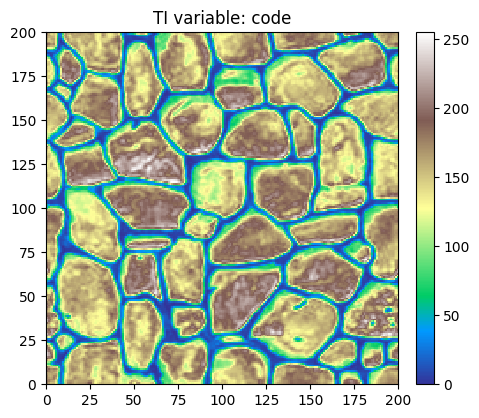

In [3]:
# Read file 
data_dir = 'data'
filename = os.path.join(data_dir, 'tiContinuous.txt')
ti = gn.img.readImageTxt(filename)

# Color settings
cmap='terrain'
vmin, vmax = ti.vmin(), ti.vmax()

# Plot
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(ti, cmap=cmap, vmin=vmin, vmax=vmax)
plt.title(f'TI variable: {ti.varname[0]}')
plt.show()

### Simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [4]:
nx, ny, nz = 200, 200, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

### Define some block data
In this example, two block data are considered. The two block contain the simulation grid cells within a disk having the same center. Setting the first radius less than the second one, the first block is included in the second one.

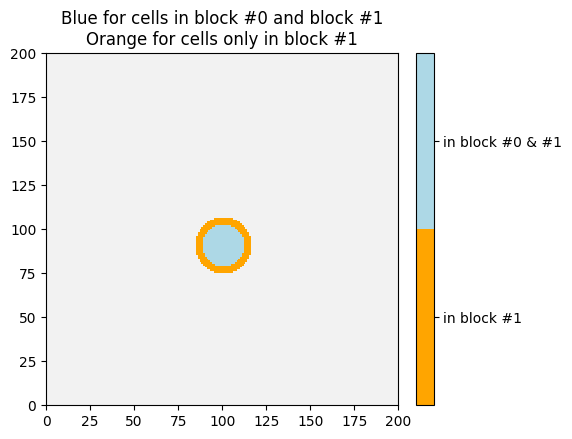

In [5]:
# disk center in the simulation grid 
cx, cy = 100.5, 90.5
# radii
r0, r1 = 12., 16.

# coordinates of cell center
x = ox + sx*(0.5 + np.arange(nx))
y = oy + sy*(0.5 + np.arange(ny))
yy, xx = np.meshgrid(y, x, indexing='ij')

# index along x and y axes of the cells that are within each block
block_ind0 = np.where((xx-cx)**2 + (yy-cy)**2 < r0**2)
block_ind1 = np.where((xx-cx)**2 + (yy-cy)**2 < r1**2)
nodeIndex0 = [(i, j, 0) for j, i in zip(*block_ind0)]
nodeIndex1 = [(i, j, 0) for j, i in zip(*block_ind1)]

n0 = len(nodeIndex0)
n1 = len(nodeIndex1)

# target mean value for each block
v0 = 200. # mean value for the small disk
vc =  10. # mean value for the crown (large disk excluding the small one) 
v1 = 1.0/n1*(n0*v0 + (n1-n0)*vc)  # mean value for the large disk (weigthed mean of v0 and vc)

# tolerance for each block
tol0 = 0.
tol1 = 0.

# activation proportion min for each block
amin0 = 0.0
amin1 = 0.0

# activation proportion max for each block
amax0 = .95
amax1 = .95

# block data
bd = gn.blockdata.BlockData(
    blockDataUsage=1,
    nblock=2,
    nodeIndex=[nodeIndex0, nodeIndex1],
    value=[v0, v1],
    tolerance=[tol0, tol1],
    activatePropMin=[amin0, amin1],
    activatePropMax=[amax0, amax1])

# Define image for viewing the block
im_block = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=1, val=0.0)
im_block.val[0][0][block_ind0] = im_block.val[0][0][block_ind0] + 1
im_block.val[0][0][block_ind1] = im_block.val[0][0][block_ind1] + 2
np.putmask(im_block.val, im_block.val==0, np.nan) 

# figure
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(im_block, categ=True, categCol=['orange', 'lightblue'], 
                       cticklabels=['in block #1','in block #0 & #1'])
plt.title('Blue for cells in block #0 and block #1\nOrange for cells only in block #1')
plt.show()

### Input for deesse and simulation

In [6]:
nreal = 15
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    TI=ti,
    distanceType='continuous',
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    blockData=bd,             # block data
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
DeeSse run complete

Warnings encountered (1 times in all):
#  1: WARNING 00115: reproducibility is not guaranteed when using multiple threads and block data conditioning
Elapsed time: 30 sec


In [7]:
# Retrieve the realizations
sim = deesse_output['sim']

# Gather the nreal realizations into one image
all_sim = gn.img.gatherImages(sim) # all_sim is one image with nreal variables

# Do statistics over all the realizations: compute the pixel-wise mean and standard deviation
sim_mean = gn.img.imageContStat(all_sim, op='mean') # do statistics (pixel-wise mean)
sim_std = gn.img.imageContStat(all_sim, op='std')   # do statistics (pixel-wise standard deviation)

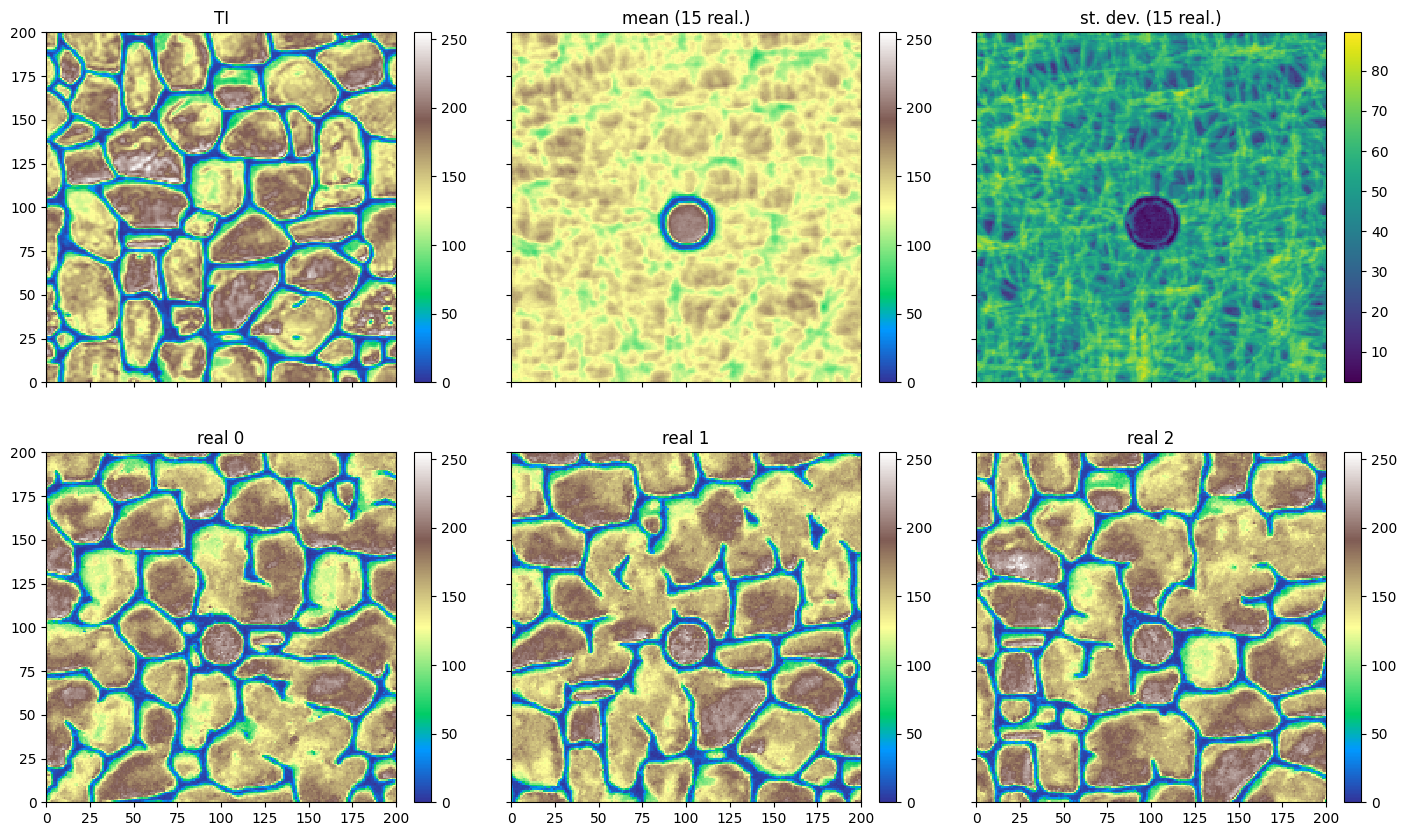

In [8]:
# Figure
fig, ax = plt.subplots(2, 3, figsize=(17, 10), sharex=True, sharey=True)

# plot TI
plt.sca(ax[0, 0])
gn.imgplot.drawImage2D(ti, cmap=cmap, vmin=vmin, vmax=vmax, title='TI')

# plot mean of realizations
plt.sca(ax[0, 1])
gn.imgplot.drawImage2D(sim_mean, cmap=cmap, vmin=vmin, vmax=vmax, title=f'mean ({nreal} real.)')

# plot standard deviation of realizations
plt.sca(ax[0, 2])
gn.imgplot.drawImage2D(sim_std, title=f'st. dev. ({nreal} real.)')

# plot two realizations
for i in [0, 1, 2]:
    # plot real #i
    plt.sca(ax[1, i])
    gn.imgplot.drawImage2D(all_sim, iv=i, cmap=cmap, vmin=vmin, vmax=vmax, title=f'real {i}')

plt.show()

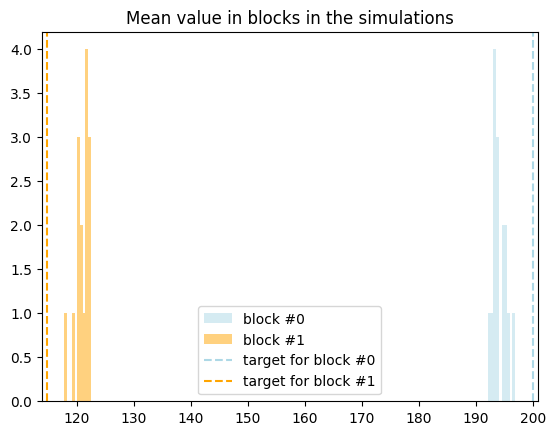

In [9]:
# Mean value in each block in the simulations
v_block = [
    np.mean(np.array([all_sim.val[:,k,j,i] for i, j, k in bd.nodeIndex[m]]).T, axis=1) 
    for m in range(bd.nblock)]

# Histogram
plt.figure()
plt.hist(v_block[0], color='lightblue', alpha=.5, label='block #0')
plt.hist(v_block[1], color='orange',    alpha=.5, label='block #1')
plt.axvline(bd.value[0], color='lightblue', ls='dashed', label='target for block #0')
plt.axvline(bd.value[1], color='orange',    ls='dashed', label='target for block #1')
plt.title('Mean value in blocks in the simulations')
plt.legend()
plt.show()